In [1]:
import numpy as np
import os

In [2]:
import torch
from torch_geometric.utils import (negative_sampling, remove_self_loops,
                                   add_self_loops)

In [3]:
import os.path as osp

In [4]:
N = 1000

In [5]:
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GAE

In [6]:
import torch

In [7]:
graph = torch.load(osp.join('../input/', 'RGG_1000nodes.pt'))

In [8]:
gS = SAGEConv(graph.num_node_features, 2, root_weight=False, bias=False)

In [9]:
class DistanceDecoder(torch.nn.Module):
    r"""The inner product decoder from the `"Variational Graph Auto-Encoders"
    <https://arxiv.org/abs/1611.07308>`_ paper

    .. math::
        \sigma(\mathbf{Z}\mathbf{Z}^{\top})

    where :math:`\mathbf{Z} \in \mathbb{R}^{N \times d}` denotes the latent
    space produced by the encoder."""

    def forward(self, z, edge_index, sigmoid=False):
        r"""Decodes the latent variables :obj:`z` into edge probabilities for
        the given node-pairs :obj:`edge_index`.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        #value = torch.sqrt(torch.pow(z[edge_index[0]] - z[edge_index[1]],2).sum(dim=1))
        value = torch.norm(z[edge_index[0]] - z[edge_index[1]], dim=1)
        return torch.sigmoid(value) if sigmoid else value

    def forward_all(self, z, sigmoid=True):
        r"""Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        adj = torch.matmul(z, z.t())
        return torch.sigmoid(adj) if sigmoid else adj

In [10]:
GAESage = GAE(gS, DistanceDecoder())

In [11]:
#gS = SAGEConv()
#GAESage.load_state_dict(torch.load( '../models/GAESage'))

In [12]:
message = GAESage.encode(graph.x, graph.edge_index.type(torch.LongTensor))

In [13]:
messagenp = message.cpu().detach().numpy()

In [14]:
import matplotlib.pyplot as plt

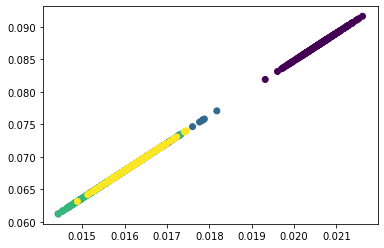

In [15]:
x = messagenp[:,0]
y = messagenp[:,1]
colors = graph.block

plt.scatter(x, y, c=colors, cmap='viridis')

plt.show() 

# Training

In [16]:
model = GAESage

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [18]:
from torch_geometric.utils import train_test_split_edges
data = train_test_split_edges(graph)

/home/math/maskey/anaconda3/envs/pyg_cuda102/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [19]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(graph.x, train_pos_edge_index)
    print(model.decoder(z, train_pos_edge_index))
    loss = model.recon_loss(z, train_pos_edge_index)
    #if args.variational:
    #   loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    print(loss)
    return float(loss)

In [20]:
def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(graph.x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [21]:
train_pos_edge_index = data.train_pos_edge_index

In [22]:
EPS = 1e-15

In [23]:
data

Data(block=[1000], num_nodes=1000, x=[1000, 1], pos=[1000, 1], val_pos_edge_index=[2, 2341], test_pos_edge_index=[2, 4683], train_pos_edge_index=[2, 79612], train_neg_adj_mask=[1000, 1000], val_neg_edge_index=[2, 2341], test_neg_edge_index=[2, 4683])

In [24]:
for epoch in range(1, 101):
    loss = train()
    print(loss)
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

tensor([0.0002, 0.0005, 0.0008,  ..., 0.0033, 0.0019, 0.0015],
       grad_fn=<CopyBackwards>)
tensor(1.3878, grad_fn=<AddBackward0>)
1.3877758979797363
Epoch: 001, AUC: 0.4075, AP: 0.4398
tensor([0.0002, 0.0005, 0.0008,  ..., 0.0033, 0.0019, 0.0015],
       grad_fn=<CopyBackwards>)
tensor(1.3878, grad_fn=<AddBackward0>)
1.3877650499343872
Epoch: 002, AUC: 0.4075, AP: 0.4398
tensor([0.0002, 0.0005, 0.0008,  ..., 0.0032, 0.0018, 0.0015],
       grad_fn=<CopyBackwards>)
tensor(1.3878, grad_fn=<AddBackward0>)
1.3877546787261963
Epoch: 003, AUC: 0.4075, AP: 0.4398
tensor([0.0002, 0.0004, 0.0008,  ..., 0.0032, 0.0018, 0.0014],
       grad_fn=<CopyBackwards>)
tensor(1.3877, grad_fn=<AddBackward0>)
1.3877294063568115
Epoch: 004, AUC: 0.4075, AP: 0.4398
tensor([0.0002, 0.0004, 0.0008,  ..., 0.0031, 0.0018, 0.0014],
       grad_fn=<CopyBackwards>)
tensor(1.3877, grad_fn=<AddBackward0>)
1.3876886367797852
Epoch: 005, AUC: 0.4075, AP: 0.4398
tensor([0.0002, 0.0004, 0.0007,  ..., 0.0031, 0.0017, 0

tensor(1.3869, grad_fn=<AddBackward0>)
1.386894941329956
Epoch: 043, AUC: 0.4075, AP: 0.4398
tensor([7.7231e-05, 1.8586e-04, 3.2201e-04,  ..., 1.3255e-03, 7.4815e-04,
        5.9418e-04], grad_fn=<CopyBackwards>)
tensor(1.3869, grad_fn=<AddBackward0>)
1.3868720531463623
Epoch: 044, AUC: 0.4075, AP: 0.4398
tensor([7.4639e-05, 1.7962e-04, 3.1121e-04,  ..., 1.2811e-03, 7.2305e-04,
        5.7424e-04], grad_fn=<CopyBackwards>)
tensor(1.3869, grad_fn=<AddBackward0>)
1.3868507146835327
Epoch: 045, AUC: 0.4075, AP: 0.4398
tensor([7.2052e-05, 1.7340e-04, 3.0043e-04,  ..., 1.2367e-03, 6.9800e-04,
        5.5435e-04], grad_fn=<CopyBackwards>)
tensor(1.3868, grad_fn=<AddBackward0>)
1.3868398666381836
Epoch: 046, AUC: 0.4075, AP: 0.4398
tensor([6.9465e-05, 1.6717e-04, 2.8964e-04,  ..., 1.1923e-03, 6.7294e-04,
        5.3445e-04], grad_fn=<CopyBackwards>)
tensor(1.3868, grad_fn=<AddBackward0>)
1.386826515197754
Epoch: 047, AUC: 0.4075, AP: 0.4398
tensor([6.6876e-05, 1.6094e-04, 2.7884e-04,  ..., 1.

tensor(1.3863, grad_fn=<AddBackward0>)
1.3863435983657837
Epoch: 082, AUC: 0.4075, AP: 0.4398
tensor([6.0027e-06, 1.4445e-05, 2.5028e-05,  ..., 1.0302e-04, 5.8149e-05,
        4.6182e-05], grad_fn=<CopyBackwards>)
tensor(1.3863, grad_fn=<AddBackward0>)
1.3863394260406494
Epoch: 083, AUC: 0.4075, AP: 0.4398
tensor([5.2831e-06, 1.2714e-05, 2.2027e-05,  ..., 9.0673e-05, 5.1178e-05,
        4.0645e-05], grad_fn=<CopyBackwards>)
tensor(1.3863, grad_fn=<AddBackward0>)
1.38633394241333
Epoch: 084, AUC: 0.4075, AP: 0.4399
tensor([4.3752e-06, 1.0529e-05, 1.8242e-05,  ..., 7.5090e-05, 4.2382e-05,
        3.3660e-05], grad_fn=<CopyBackwards>)
tensor(1.3863, grad_fn=<AddBackward0>)
1.3863271474838257
Epoch: 085, AUC: 0.4075, AP: 0.4399
tensor([3.2529e-06, 7.8280e-06, 1.3563e-05,  ..., 5.5829e-05, 3.1511e-05,
        2.5026e-05], grad_fn=<CopyBackwards>)
tensor(1.3863, grad_fn=<AddBackward0>)
1.3863191604614258
Epoch: 086, AUC: 0.4075, AP: 0.4399
tensor([1.9923e-06, 4.7945e-06, 8.3068e-06,  ..., 3.

In [25]:
z = model.encode(graph.x, train_pos_edge_index)

In [26]:
model.decoder(z, train_pos_edge_index, sigmoid=True)

tensor([0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
       grad_fn=<SigmoidBackward>)

In [27]:
value[:10]

NameError: name 'value' is not defined

In [ ]:
import sys
sys.path.insert(1,'../src')
from TwoLayerGraphSage import GCN

In [ ]:
model = GAE(GCN(data.num_node_features))

In [ ]:
model.load_state_dict(torch.load( '../models/TwoLayerGraphSage.pt'))

In [ ]:
import torch.nn.functional as F

In [ ]:
for epoch in range(1, 101):
    loss = train()

    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

In [ ]:
Z = model.encode(graph.x, train_pos_edge_index)

In [ ]:
Z = Z.detach().numpy()

In [ ]:
Z

In [ ]:
x = Z[:,0]
y = Z[:,1]
colors = graph.block

plt.scatter(x, y, c=colors, cmap='viridis')

plt.show() 

In [ ]:
pos_loss = model.decoder(Z, train_pos_edge_index)

In [ ]:
pos_loss

In [ ]:
train_pos_edge_index

In [ ]:
len(pos_loss)

In [ ]:
value = (Z[train_pos_edge_index[0]] * Z[train_pos_edge_index[1]]).sum(dim=1)

In [ ]:
value

In [ ]:
train_pos_edge_index

In [ ]:
hi = torch.dot(Z[0], Z[4])

In [ ]:
hi

In [ ]:
message = GAESage.encode(graph.x, graph.edge_index.type(torch.LongTensor))

In [ ]:
value = (graph.x[graph.edge_index.type(torch.LongTensor)[0]] * graph.x[graph.edge_index.type(torch.LongTensor)[1]]).sum(dim=1)

In [ ]:
value

In [ ]:
dec = GAESage.decoder(graph.x, graph.edge_index.type(torch.LongTensor), sigmoid = False)

In [ ]:
dec

The sigmoidal funciton is the problem, if we consider the things above dec with sig False produces an interpretable output. Using sigmoid jsut squashes everything to almost the same value
--> Remove the sigmoidal funcion by writing the GAE class again simply with SIGMoid false in Rec los and test